# Identifying the diffusion equation from a random walk

Samuel Rudy, 2016

Here we take various lengths of a random walk where $x_{j+1} \sim \mathcal{N}(x_j, dt)$ and see if we can identify the diffusion equation.  As expected, it works better for longer series.

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12,6)
import numpy as np
from PDE_FIND import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
# set seed = 0
numpy.random.seed(0)

N = 24
lengths = [int(10**j) for j in 2+np.arange(N+1)*4.0/N]
err = {}
for l in range(N+1): err[l] = []
sparsity_err = np.zeros(len(lengths))
trials = 10
w_true = np.zeros((16,1))
w_true[8] = 0.5

for trial in range(trials):
    
    print "Trial:", trial+1, "of", trials
    
    # generate a new time series
    dt = 0.01
    advection = 0 # it has some trouble with advection
    pos = np.cumsum(np.sqrt(dt)*np.random.randn(lengths[-1])) + dt*advection*np.arange(lengths[-1])

    # fit various lengths of it to a pde
    for l in range(len(lengths)):

        length = lengths[l]
        P = {}
        M = 0
        m = 5
        
        # More bins for longer time series.  We just need to make sure there aren't too many bins for how many points we have
        n = int(20*log(length))
        for j in range(m): P[j] = []

        for i in range(length-m):

            # center
            y = pos[i+1:i+m+1] - pos[i]
            M = max([M, max(abs(y))])

            # add to distribution
            for j in range(m):
                P[j].append(y[j])

        bins = np.linspace(-M,M,n+1)
        x = linspace(M*(1/n-1),M*(1-1/n),n)
        dx = x[2]-x[1]
        
        U = np.zeros((n,m))
        for i in range(m):
            U[:,i] = np.histogram(P[i],bins)[0]/float(dx*(len(pos)-m))

        Ut,R,rhs_des = build_linear_system(U, dt, dx, D=3, P=3, time_diff = 'FD', deg_x = 5, width_x = np.max([10,n/10]))
        lam = 10**-3*length
        d_tol_2 = 0.001/dx
        d_tol_0 = 0.001/dx
        
        # Try two different normalizations and see which one performs better.  They should get the same answer for most of 
        # the longer runs.
        split = 0.8
        N = len(Ut)
        train = np.random.choice(N, int(N*split), replace = False)
        test = [i for i in np.arange(N) if i not in train]
        
        w2 = TrainSTRidge(R[train,:], Ut[train], lam, d_tol_2, normalize = 2)
        w0 = TrainSTRidge(R[train,:], Ut[train], lam, d_tol_0, normalize = 0)
                
        err2 = np.linalg.norm(Ut[test] - R[test,:].dot(w2)) + 0.01*np.linalg.norm(Ut[test], 2)*np.count_nonzero(w2)
        err0 = np.linalg.norm(Ut[test] - R[test,:].dot(w0)) + 0.01*np.linalg.norm(Ut[test], 2)*np.count_nonzero(w0)
        
        w = [w0,w2]
        error = [err0,err2]
        method = argmin(error)
        w_r = w[method]
        err[l].append(np.linalg.norm(w_r - w_true, 1))

        if trial == 0:
            print "Length of time series used: ", length
#             print "Condition Number: ", cond(R)
#             print "Regularization: ", ['unregularized','2 norm'][method] 
            print_pde(w_r, rhs_des)
        
        w_r = np.array(w_r)
        sparsity_err[l] += float(len(np.where(w_r[0:5] != 0)[0]) + len(np.where(w_r[7:8] != 0)[0]) + int(w_r[6] == 0))/trials
        
# print err
# print sparsity_err

Trial: 1 of 10
Length of time series used:  100
u_t = (-121283487.459491 -0.000000i)u^3
   
Length of time series used:  146
u_t = (-105893062.687726 -0.000000i)u^3
   
Length of time series used:  215
u_t = (-40949708.875765 -0.000000i)u^3
   
Length of time series used:  316
u_t = (-25929330.762661 -0.000000i)u^3
   
Length of time series used:  464
u_t = (-9727002.518794 -0.000000i)u^3
   
Length of time series used:  681
u_t = (0.097842 +0.000000i)u_{xx}
   
Length of time series used:  1000
u_t = (0.132088 +0.000000i)u_{xx}
   
Length of time series used:  1467
u_t = (0.292211 +0.000000i)u_{xx}
   
Length of time series used:  2154
u_t = (0.336024 -0.000000i)u_{xx}
   
Length of time series used:  3162
u_t = (0.401712 +0.000000i)u_{xx}
   
Length of time series used:  4641
u_t = (0.409962 -0.000000i)u_{xx}
   
Length of time series used:  6812
u_t = (0.455302 -0.000000i)u_{xx}
   
Length of time series used:  10000
u_t = (0.436203 -0.000000i)u_{xx}
   
Length of time series used: 

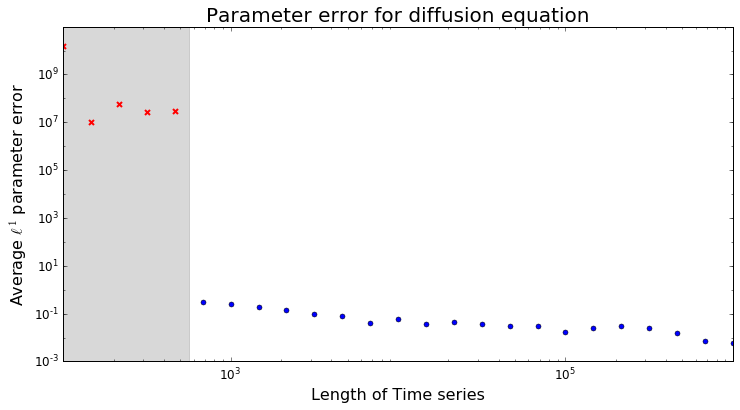

In [3]:
# pylab.rcParams['figure.figsize'] = (3.5,1.7)
err2 = [np.mean(j) for _,j in err.items()]
min_len = np.max(np.where(np.array(err2) >= 0.5))+1

loglog(lengths[0:min_len], err2[0:min_len], 'x', color = 'r', mew=2, ms=5)
loglog(lengths[min_len:], err2[min_len:], 'o', color = 'b', ms = 5)
yticks([10**-3,10**-1,10**1,10**3,10**5, 10**7, 10**9], fontsize = 12)
xticks([10**3,10**5], fontsize = 12)

pareto_front = lengths[min_len]/10**(1.0/12)
axvspan(100,pareto_front, alpha=0.3, color='gray')
xlabel('Length of Time series', fontsize = 16)
ylabel(r'Average $\ell^1$ parameter error', fontsize = 16)
title('Parameter error for diffusion equation', fontsize = 20)